# Prosjektoppgave MET2010

## Innholdsfotegnelse
1. Innledning
2. Datainnhenting og strukturering
3. 
4. 
5. 
6. 

## 1. Innledning

I denne prosjektoppgaven vil jeg ta for meg data omhandlende vær, stråling og forurensing i Trondheim, dette for å se en sammenheng mellom disse og også kunne predikere når det er høyest andel av svevestøv. 

## 2. Datainnhenting

Starter med å importere de relevante pakkene, for deretter å innhente værdata fra Metrologisk institutt. Målingene er gjort på Voll målestasjon i Trondheim. 

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [229]:
weather = pd.read_csv("data/Temperatur_regn.csv", sep=";", decimal=",")

In [230]:
weather.tail()

,Navn,Stasjon,Tid(norsk normaltid),Maksimumstemperatur (døgn),Minimumstemperatur (døgn),Høyeste middelvind (døgn),Nedbør (døgn)
2553,Trondheim - Voll,SN68860,28.12.2021,-4.5,-10.1,"1,6",0.0
2554,Trondheim - Voll,SN68860,29.12.2021,-4.5,-9.7,"2,4",0.0
2555,Trondheim - Voll,SN68860,30.12.2021,-0.4,-6.5,"2,9",0.0
2556,Trondheim - Voll,SN68860,31.12.2021,2.4,-1.9,"4,8",3.2
2557,"Data er gyldig per 16.11.2022 (CC BY 4.0), Met...",NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
weather.drop(weather.tail(1).index,inplace=True)

In [232]:
weather.rename(columns={"Tid(norsk normaltid)" : "Tid"}, inplace=True)
weather.rename(columns={"Maksimumstemperatur (døgn)" : "Max_Temp"}, inplace=True)
weather.rename(columns={"Minimumstemperatur (døgn)" : "Min_Temp"}, inplace=True)
weather.rename(columns={"Høyeste middelvind (døgn)" : "Max_Wind"}, inplace=True)
weather.rename(columns={"Nedbør (døgn)" : "Rain"}, inplace=True)

In [233]:
weather.set_index("Tid", inplace=True)
weather.index = pd.to_datetime(weather.index, format="%d.%m.%Y").date

In [234]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 2015-01-01 to 2021-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Navn      2557 non-null   object 
 1   Stasjon   2557 non-null   object 
 2   Max_Temp  2557 non-null   float64
 3   Min_Temp  2557 non-null   float64
 4   Max_Wind  2557 non-null   object 
 5   Rain      2557 non-null   float64
dtypes: float64(3), object(3)
memory usage: 139.8+ KB


In [235]:
weather["Is_Rain"] = np.where(weather.Rain>0, 1, 0)

In [236]:
weather["Max_Wind"] = weather.Max_Wind.str.replace(',','.')
weather["Max_Wind"] = weather.Max_Wind.str.replace('-','0')


In [237]:
weather["Max_Wind"] = weather.Max_Wind.astype("float64")

In [238]:
uv = pd.read_table("https://raw.githubusercontent.com/uvnrpa/Daily_Doses/master/TRH_daily.txt", skiprows=31)

In [239]:
length_period = len(weather)

In [240]:
uv = uv.tail(length_period)

In [241]:
weather["UVA"] = uv["UVA"].to_numpy()
weather["UVB"] = uv["UVB"].to_numpy()

In [242]:
weather.tail()

,Navn,Stasjon,Max_Temp,Min_Temp,Max_Wind,Rain,Is_Rain,UVA,UVB
2021-12-27,Trondheim - Voll,SN68860,0.2,-7.3,4.2,1.2,1,24021.0,57.144
2021-12-28,Trondheim - Voll,SN68860,-4.5,-10.1,1.6,0.0,0,23988.0,46.431
2021-12-29,Trondheim - Voll,SN68860,-4.5,-9.7,2.4,0.0,0,19061.0,32.673
2021-12-30,Trondheim - Voll,SN68860,-0.4,-6.5,2.9,0.0,0,24308.0,30.534
2021-12-31,Trondheim - Voll,SN68860,2.4,-1.9,4.8,3.2,1,17993.0,19.491


In [243]:
weather = weather.drop("Stasjon", axis=1)

In [244]:
pressure = pd.read_csv("data/Lufttrykk.csv", sep=";", decimal=",")
pressure.drop(pressure.tail(1).index,inplace=True)

In [245]:
pressure.columns

Index(['Navn', 'Stasjon', 'Tid(norsk normaltid)',
       'Høyeste lufttrykk i havnivå (døgn)',
       'Laveste lufttrykk i havnivå (døgn)'],
      dtype='object')

In [246]:
weather["Max_Pressure"] = pressure["Høyeste lufttrykk i havnivå (døgn)"].to_numpy()
weather["Min_Pressure"] = pressure["Laveste lufttrykk i havnivå (døgn)"].to_numpy()

In [247]:
weather.tail()

,Navn,Max_Temp,Min_Temp,Max_Wind,Rain,Is_Rain,UVA,UVB,Max_Pressure,Min_Pressure
2021-12-27,Trondheim - Voll,0.2,-7.3,4.2,1.2,1,24021.0,57.144,1007.9,1002.2
2021-12-28,Trondheim - Voll,-4.5,-10.1,1.6,0.0,0,23988.0,46.431,1001.6,998.7
2021-12-29,Trondheim - Voll,-4.5,-9.7,2.4,0.0,0,19061.0,32.673,1000.6,996.8
2021-12-30,Trondheim - Voll,-0.4,-6.5,2.9,0.0,0,24308.0,30.534,996.4,987.3
2021-12-31,Trondheim - Voll,2.4,-1.9,4.8,3.2,1,17993.0,19.491,1009.9,995.1


In [248]:
power2015 = pd.read_csv("data/poweruse_2015.csv")
power2016 = pd.read_csv("data/poweruse_2016.csv")
power2017 = pd.read_csv("data/poweruse_2017.csv")
power2018 = pd.read_csv("data/poweruse_2018.csv")
power2019 = pd.read_csv("data/poweruse_2019.csv")
power2020 = pd.read_csv("data/poweruse_2020.csv")
power2021 = pd.read_csv("data/poweruse_2021.csv")

In [249]:
power_list = [power2015, power2016, power2017, power2018, power2019, power2020, power2021]

In [250]:
daily_power = pd.DataFrame()
daily_power = pd.concat(power_list, ignore_index=True)

In [251]:
daily_power.drop(daily_power.head(3).index,inplace=True)
daily_power.drop(daily_power.tail(2).index,inplace=True)
daily_power.reset_index(inplace=True)

In [252]:
weather_power_use = weather.copy()

In [253]:
weather_power_use["Max_Power"] = daily_power["Max Total Load [MW] - BZN|NO3"].to_numpy()
weather_power_use["Min_Power"] = daily_power["Min Total Load [MW] - BZN|NO3"].to_numpy()

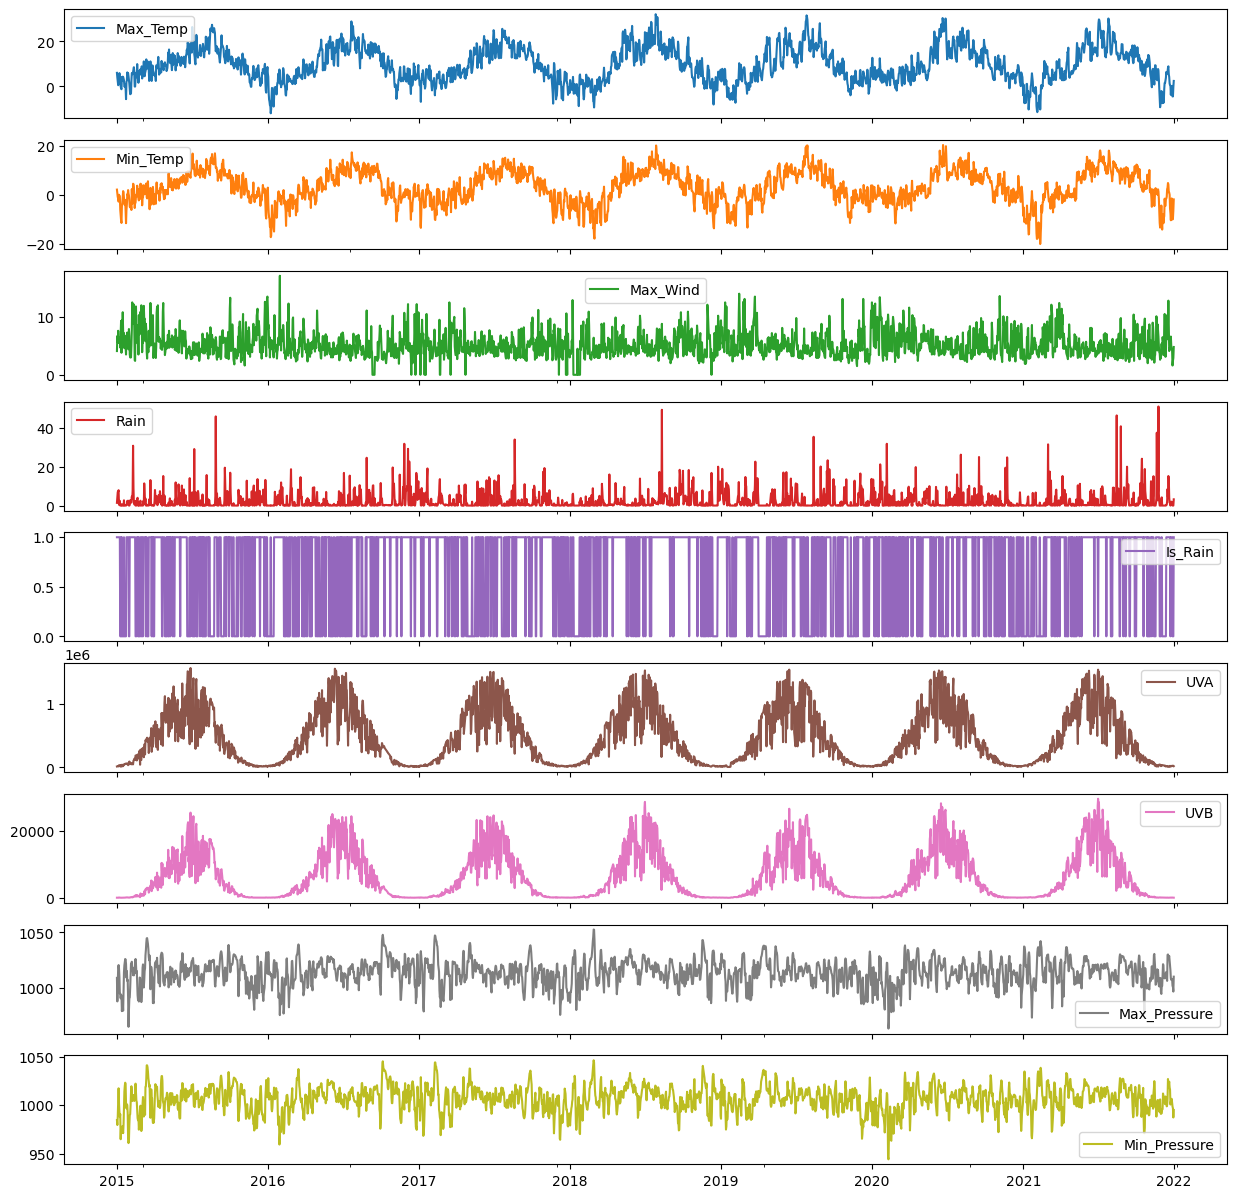

In [254]:
weather.plot(subplots = True, figsize=(15,15))
plt.show()